<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/RF_Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF Snow Instability Analysis - Modern Model

This notebook analyzes SNOWPACK PRO files using the Random Forest instability model. It automatically downloads and selects the best model version for your Python environment.

## 🚀 Quick Start

1. **Click "Run all"** in the Runtime menu (or run each cell sequentially with Shift+Enter)
2. **Upload your PRO file** when prompted (or use the example file)
3. **View the results** - plots will appear automatically

## 📋 What You Need

- A SNOWPACK PRO file (`.pro` format) - you can upload your own file or use the example
- That's it! Everything else is downloaded automatically.

## 📊 What This Notebook Does

- **Single Profile Analysis**: Analyze a specific timestamp from your PRO file
- **Seasonal Evolution**: Track instability probabilities over time
- **CSV Export**: Export daily instability metrics for further analysis

## ⚠️ Important Notes

- `slopeangle` only affects the MF-crust penetration-depth calculation
- `P_unstable` shows layer-wise instability probability (not direct hazard rating)
- Always combine results with field observations before making decisions

## 🔬 Original Model

Based on the Random Forest snow instability model by:
- **Repository**: [WSL/SLF GitLab - Random Forest Snow Instability Model](https://git.wsl.ch/mayers/random_forest_snow_instability_model.git)
- **Authors**: mayers, fherla (WSL Institute for Snow and Avalanche Research SLF)

## 📦 Step 1: Setup Environment

This cell checks your Python environment and prepares the workspace. Just run it - no changes needed!


In [ ]:
# Step 1: Setup environment and check Python version
import sys
import platform
import pathlib
import datetime

try:
    import sklearn
    print("✓ Python version:", sys.version.split()[0])
    print("✓ Platform:", platform.system())
    print("✓ scikit-learn version:", sklearn.__version__)
except ImportError:
    print("⚠ scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "packaging"])
    import sklearn
    print("✓ scikit-learn installed:", sklearn.__version__)

# Setup workspace directory
rf_nb_dir = pathlib.Path.cwd()
rf_mod_dir = (rf_nb_dir / "rf_instability_modern").resolve()
rf_mod_dir.mkdir(parents=True, exist_ok=True)

# Add to Python path so we can import helper modules
if str(rf_mod_dir) not in sys.path:
    sys.path.insert(0, str(rf_mod_dir))

print(f"\n✓ Workspace ready: {rf_mod_dir}")
print("✓ Ready to download model files...")


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
Platform: macOS-10.16-x86_64-i386-64bit
scikit-learn: 1.5.1

RF module directory: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_instability_modern


In [ ]:
## 📥 Step 2: Download Model Files

This cell automatically downloads the RF model files from CRAN. It may take 30-60 seconds on first run.
import tarfile, urllib.request, io

rf_inst_py_dir = rf_mod_dir / "inst_python"
rf_inst_py_dir.mkdir(exist_ok=True)

# Check if files already exist
rf_has_sav_files = len(list(rf_inst_py_dir.glob("*.sav"))) > 0
rf_has_py_modules = (rf_mod_dir / "readProfile.py").exists() and (rf_mod_dir / "pyunstable.py").exists()

if rf_has_sav_files and rf_has_py_modules:
    print("✓ Files already present - skipping download")
else:
    print("Downloading CRAN tarball...")
    rf_candidates = ["0.4.3", "0.4.2", "0.4.1", "0.4.0"]
    rf_base_live = "https://cran.r-project.org/src/contrib"
    rf_base_archive = "https://cran.r-project.org/src/contrib/Archive/sarp.snowprofile.pyface"
    rf_downloaded = None

    for rf_ver in rf_candidates:
        rf_urls = [
            f"{rf_base_live}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
            f"{rf_base_archive}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
        ]
        for rf_url in rf_urls:
            try:
                with urllib.request.urlopen(rf_url, timeout=30) as rf_response:
                    rf_data = rf_response.read()
                rf_downloaded = (rf_ver, rf_data)
                print("Downloaded:", rf_url)
                break
            except Exception:
                continue
        if rf_downloaded:
            break

    if rf_downloaded:
        rf_ver, rf_data = rf_downloaded
        with tarfile.open(fileobj=io.BytesIO(rf_data), mode="r:gz") as rf_tar:
            # Extract .sav model files
            rf_sav_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".sav")
            ]
            if rf_sav_members:
                for rf_member in rf_sav_members:
                    rf_target = rf_inst_py_dir / pathlib.Path(rf_member.name).name
                    with rf_tar.extractfile(rf_member) as rf_source:
                        if rf_source is not None:
                            rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_sav_members)} .sav files to: {rf_inst_py_dir}")
            
            # Extract Python helper modules
            rf_py_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".py")
            ]
            if rf_py_members:
                for rf_member in rf_py_members:
                    rf_filename = pathlib.Path(rf_member.name).name
                    rf_target = rf_mod_dir / rf_filename
                    if not rf_target.exists():
                        with rf_tar.extractfile(rf_member) as rf_source:
                            if rf_source:
                                rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_py_members)} Python helper modules")
    else:
        print("WARNING: Could not fetch the CRAN tarball. Options:")
        print(f"  - Upload a compatible .sav into: {rf_inst_py_dir}")
        print("  - Or mount Drive and set rf_model_path manually.")


✓ Files already present - skipping download


In [3]:
# Load RF model (auto-selects best version for your scikit-learn)
def rf_select_model_path(inst_dir: pathlib.Path, skl_ver: str):
    rf_files = sorted(inst_dir.glob("*.sav"))
    if not rf_files:
        return None, "No .sav files present."
    rf_version = version.parse(skl_ver)
    if rf_version >= version.parse("1.5"):
        rf_prefs = ["scikit152", "scikit121", "published_2022"]
    elif rf_version >= version.parse("1.2"):
        rf_prefs = ["scikit121", "scikit152", "published_2022"]
    else:
        rf_prefs = ["published_2022", "scikit121", "scikit152"]
    for rf_key in rf_prefs:
        for rf_file in rf_files:
            if rf_key in rf_file.name:
                return rf_file, None
    return rf_files[-1], "Heuristic fallback: picked the last available .sav"

rf_skl_ver = sklearn.__version__
rf_model_path, rf_model_warning = rf_select_model_path(rf_inst_py_dir, rf_skl_ver)

if rf_model_path is None:
    raise RuntimeError(f"No model file found. Upload a compatible .sav into: {rf_inst_py_dir}")

print("scikit-learn:", rf_skl_ver)
print("Chosen model:", rf_model_path.name)
if rf_model_warning:
    print("Note:", rf_model_warning)

rf_model_modern = joblib.load(rf_model_path)
print("✓ Model loaded successfully")


scikit-learn: 1.5.1
Chosen model: RF_instability_model_scikit152_2024.sav
✓ Model loaded successfully


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Import helper modules
import importlib
import get_RF, readProfile, plt_RF
importlib.reload(plt_RF)  # Reload to pick up any code changes

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("✓ Helper modules imported")


✓ Helper modules imported


## Single Profile Analysis

Analyze a specific timestamp from a PRO file.


Reading file:  snowprofiles/WFJ2_2017.pro


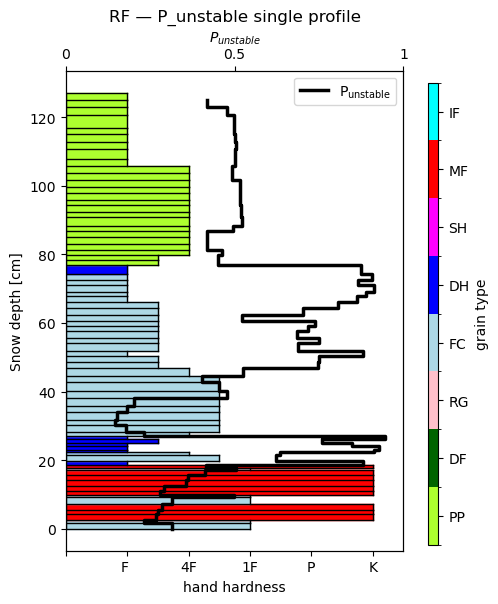

In [5]:
# Single profile analysis
def rf_fix_punstable(df: pd.DataFrame, column: str = 'P_unstable') -> pd.DataFrame:
    """Ensure instability probabilities sit inside [0, 1], with gentle auto-scaling."""
    if column not in df.columns:
        return df
    rf_vals = pd.to_numeric(df[column], errors='coerce')
    rf_valid = rf_vals.dropna()
    if len(rf_valid) == 0:
        return df
    rf_min, rf_max = float(rf_valid.min()), float(rf_valid.max())
    if rf_max <= 1.0 + 1e-6 and rf_min >= -1e-6:
        df[column] = rf_vals.clip(0.0, 1.0)
    elif rf_max <= 100.0 and rf_min >= 0.0:
        df[column] = (rf_vals / 100.0).clip(0.0, 1.0)
    else:
        df[column] = rf_vals.clip(0.0, 1.0)
    return df

# Find example PRO file
rf_example_pro = None
rf_example_candidates = [
    pathlib.Path("snowprofiles/WFJ2_2017.pro"),
    pathlib.Path("../input_example/WFJ2_2017.pro"),
    pathlib.Path("input_example/WFJ2_2017.pro"),
]
for rf_candidate in rf_example_candidates:
    if rf_candidate.exists():
        rf_example_pro = str(rf_candidate)
        break

if rf_example_pro:
    rf_timestamp = datetime.datetime(2017, 2, 1, 11, 0)
    rf_slopeangle = 0
    
    rf_profile = readProfile.read_profile(rf_example_pro, rf_timestamp, remove_soil=True)
    rf_df_profile = get_RF.create_RFprof(rf_profile, rf_slopeangle, rf_model_modern)
    rf_df_profile = rf_fix_punstable(rf_df_profile)
    
    rf_fig, rf_ax = plt.subplots(figsize=(5, 6))
    plt_RF.plot_sp_single_P0(rf_fig, rf_ax, rf_df_profile, var='P_unstable', colorbar=True)
    rf_ax.set_title("RF — P_unstable single profile")
    plt.show()
else:
    print("No example .pro file found. Set rf_example_pro to your PRO file path.")


## Seasonal Evolution

Track instability probabilities over time for a date range.


Reading file:  snowprofiles/WFJ2_2017.pro


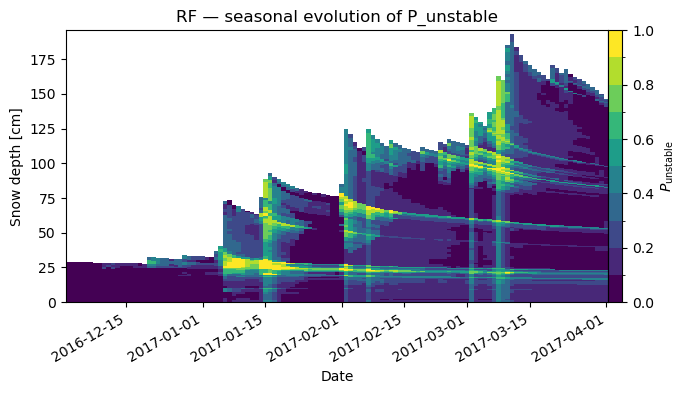

In [6]:
# Seasonal evolution analysis
if rf_example_pro:
    rf_year = 2017
    rf_start = pd.Timestamp(rf_year - 1, 12, 1, 12, 0)
    rf_stop = pd.Timestamp(rf_year, 4, 1, 12, 0)
    rf_slopeangle = 0
    
    rf_profiles_all = readProfile.read_profile(rf_example_pro, remove_soil=True)
    rf_profiles_data = rf_profiles_all.get('data', {}) if isinstance(rf_profiles_all, dict) else {}
    
    rf_dates = pd.date_range(rf_start, rf_stop, freq='D')
    rf_rows = []
    for rf_ts in rf_dates:
        rf_profile_daily = rf_profiles_data.get(rf_ts)
        if rf_profile_daily is None or len(rf_profile_daily.get('height', [])) == 0:
            continue
        rf_df_daily = get_RF.create_RFprof(rf_profile_daily, rf_slopeangle, rf_model_modern)
        rf_df_daily = rf_fix_punstable(rf_df_daily)
        if 'layer_top' in rf_df_daily:
            rf_df_daily['HS'] = rf_df_daily['layer_top'].iloc[-1]
        rf_df_daily.insert(0, 'datetime', rf_ts)
        rf_rows.append(rf_df_daily)
    
    if rf_rows:
        rf_evo = pd.concat(rf_rows, ignore_index=True)
        rf_evo = rf_evo.sort_values(['datetime', 'layer_top']).reset_index(drop=True)
        
        if rf_evo['datetime'].nunique() >= 2:
            rf_fig_evo, rf_ax_evo = plt.subplots(figsize=(7, 4))
            plt_RF.plot_evo_SP(rf_evo, rf_fig_evo, rf_ax_evo, rf_start, rf_stop, 
                              var='P_unstable', colorbar=True, resolution='D')
            rf_ax_evo.set_title("RF — seasonal evolution of P_unstable")
            plt.show()
        else:
            print(f"Need ≥2 daily profiles; found {rf_evo['datetime'].nunique()}. Adjust rf_start/rf_stop.")
    else:
        print("No profiles found between", rf_start, "and", rf_stop)
else:
    print("Set rf_example_pro above to run seasonal evolution.")


## Notes

- If unpickling fails, upload another `.sav` from the CRAN `inst/python` folder into `rf_instability_modern/inst_python`, or temporarily pin scikit-learn to a version that matches the available filenames.
- `P_unstable` indicates layer-wise instability probability; combine it with field observations before acting on results.
- `slopeangle` only steers the MF-crust penetration-depth heuristic and does not change the underlying trained model.
